# Embedding images
### Data sources
- Cifar-100
- Imagenet
- https://www.kaggle.com/competitions/google-universal-image-embedding/discussion/340489
- Pinging Google image & pinterest
- https://paperswithcode.com/dataset/inaturalist

### Research papers
- [Sharpness-Awareness minimization for efficiently improving generalization](https://arxiv.org/pdf/2010.01412v3.pdf)
- [Size matters: about the image size importance](https://arxiv.org/pdf/2102.01582.pdf)
- [Image classification CIFAR-100 with PyTorch](https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1)

In [65]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import DataLoader
from torch import nn
import torch
from tqdm.autonotebook import tqdm

import torchvision
from torchvision import transforms
from src.vae_resnet import Resnet_VAE

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [9]:
def show_images(images, labels, nmax=64):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([]); ax.set_yticks([]); 
    ax.imshow(make_grid((images[:nmax]), nrow=8).permute(1, 2, 0))
    #ax.set_title(labels)
def show_batch(dl, nmax=64):
    for images, labels in dl:
        show_images(images, labels, nmax)
        break

In [167]:
BATCH_SIZE = 32
LATENT_DIMENSION = 64
IMAGE_RESIZED = 64

normalize_stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_cifar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4,padding_mode="reflect"),
    transforms.Resize(size=(IMAGE_RESIZED,IMAGE_RESIZED)),
    transforms.ToTensor(),
    #transforms.Normalize(*normalize_stats)
])

test_cifar_transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_RESIZED,IMAGE_RESIZED)),
    transforms.ToTensor(),
    #transforms.Normalize(*normalize_stats)
])

trainset = torchvision.datasets.CIFAR100(root='./data',
                                         download=True,
                                         train=True,
                                         transform=train_cifar_transform
                                        )
testset = torchvision.datasets.CIFAR100(root='./data',
                                         download=True,
                                         train=False,
                                         transform=test_cifar_transform
                                        )   
                                                
train_dl = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
test_dl = DataLoader(testset, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


In [100]:
import pytorch_lightning as pl

class ResNetVAE(pl.LightningModule):
    def __init__(self, latent_dimension):
        super().__init__()
        # define model and loss
        self.model = Resnet_VAE(latent_dimension)
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # implement single training step
        x, y = batch
        decoded_x, _ = self(x)
        
        loss = self.loss(decoded_x, x)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        decoded_x, latent_vector = self(x)
        
        loss = self.loss(decoded_x, x)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        # choose your optimizer
        return torch.optim.Adam(self.parameters(), lr=0.005)
    
    def predict_step(self, batch, batch_idx):#, dataloader_idx=0):
        x, y = batch
        _, latent_vector = self(x)
        return latent_vector

In [5]:
checkpoint_callback = ModelCheckpoint(dirpath="checkpoints",
        filename="best-checkpoint",
        save_top_k=3,
        verbose=True,
        monitor="train_loss",
        mode="min")

logger = TensorBoardLogger("lightning_logs", name="images_embeddings")

early_stopping_callback = EarlyStopping(monitor="train_loss", patience=5)

progress_bar_callback = TQDMProgressBar(refresh_rate=1)

model = ResNetVAE(LATENT_DIMENSION)
trainer = pl.Trainer(
    max_epochs=5, # set number of epochs
    #gpus=1,
    logger=logger,
    enable_checkpointing=checkpoint_callback,
    callbacks=[early_stopping_callback,progress_bar_callback]
)
trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Resnet_VAE | 23.8 M
1 | loss  | MSELoss    | 0     
-------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.247    Total estimated model params size (MB)
/Users/user/Library/Caches/pypoetry/virtualenvs/image-embedding-QrS6mgTU-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   2%|▋                                             | 6/391 [01:30<1:37:18, 15.17s/it, loss=1.76, v_num=0, train_loss=1.530]

/Users/user/Library/Caches/pypoetry/virtualenvs/image-embedding-QrS6mgTU-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Testing, evaluation

In [212]:
LATENT_DIMENSION = 256
model = ResNetVAE(LATENT_DIMENSION)
model.load_state_dict(torch.load('model/dim256_mdl.pt'))
model.eval();

In [213]:
embeddings = torch.tensor([LATENT_DIMENSION*[0]])
ylabels = torch.tensor([])
with torch.no_grad():
    for idx, (batch, ylabel) in enumerate(test_dl):
        print("Batch %i / %i" % (idx+1,len(test_dl)), end='\r')
        _, latent_vector = model(batch)
        
        assert latent_vector.shape[0] == ylabel.shape[0]
        
        ylabels = torch.cat((ylabels, ylabel))
        embeddings = torch.cat((embeddings,latent_vector), axis=0)
    
    embeddings = embeddings[1:,:]

In [214]:
ylabel.shape, batch.shape, latent_vector.shape, embeddings.shape

(torch.Size([16]),
 torch.Size([16, 3, 64, 64]),
 torch.Size([16, 256]),
 torch.Size([10000, 256]))

In [215]:
import umap
import pandas as pd
import seaborn as sns

In [216]:
lower_dim_space = umap.UMAP(n_neighbors=10,\
          min_dist=0.15,\
          metric='cosine').fit_transform(embeddings.numpy())

In [217]:
labels = pd.DataFrame(ylabels.numpy(), columns=['label'])
df_embeddings = labels.join(pd.DataFrame(lower_dim_space, columns=['x','y']))
df_embeddings['label'] = df_embeddings['label'].astype(int)
df_embeddings.shape

(10000, 3)

Text(0.5, 1.0, 'Image embeddings')

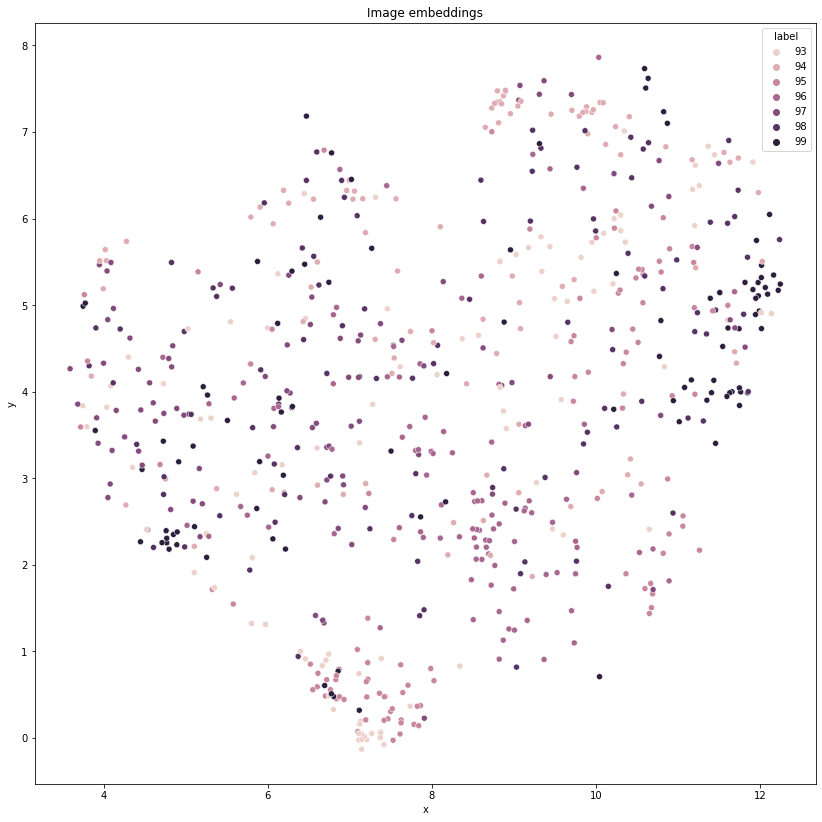

In [218]:
GENRE_TO_PLOT = ['Sports','Adventure', 'Strategy', 'Role Playing', 'Arcade', 'Action', 'Puzzle',
       'Simulation', 'Casual','Casino']

plt.figure(figsize=(14, 14))
sns.scatterplot(data=df_embeddings[df_embeddings.label > 92], x='x', y='y', hue='label')
ax = plt.gca()
ax.set_title("Image embeddings")

In [219]:
map_location = {'cuda:0':'cpu'}
mymodel = ResNetVAE.load_from_checkpoint('model/mdl.pt', 
                                         map_location=map_location, 
                                         latent_dimension=128)
trainer = Trainer()
predictions = trainer.predict(mymodel, dataloaders=test_dl)

KeyError: 'state_dict'

In [220]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid 

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([]); ax.set_yticks([]); 
    ax.imshow(make_grid((images[:nmax]), nrow=8).permute(1, 2, 0))
    #ax.set_title(labels)
def show_batch(model, input_image, nmax=64):
    model.eval()
    with torch.no_grad():
        output_image, _ = model(input_image)
        images = [input_image,output_image]
        show_images(images, nmax)

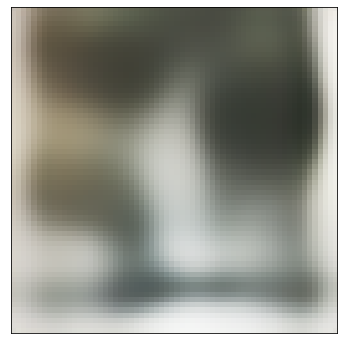

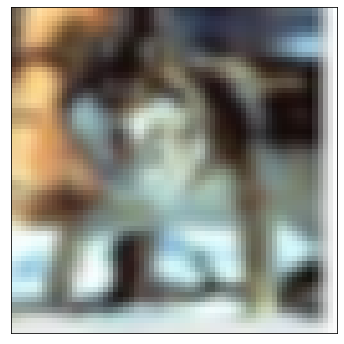

In [226]:
im_idx = 9231
model.eval()
with torch.no_grad():
    output_image, _ = model(testset[im_idx][0].view(1,3,64,64))
show_images(output_image[0])
show_images(testset[im_idx][0])